In [1]:
from datetime import datetime
print(f'Päivitetty {datetime.now().date()} / Aki Taanila')

Päivitetty 2024-05-17 / Aki Taanila


# Luottokorttipetokset

Data ja sen kuvaus löytyy lähteestä: https://www.kaggle.com/mlg-ulb/creditcardfraud

Datassa ei ole alkuperäisiä selittäviä muuttujia, vaan niistä pääkomponenttianalyysilla muodostetut uudet muuttujat (sekä tietosuojan että tilastotieteellisten syiden takia). **Class**-muuttuja on kohdemuuttuja (0 = 'ei petos', 1 = 'petos').

Petoksia on vähän suhteessa kaikkiin luottokorttitapahtumiin. Tämän vuoksi data on syytä tasapainottaa. Käytän tasapainottamiseen imbalanced-learn-kirjastoa, joka ei ole Anacondassa valmiiksi asennettuna. Sen voi asentaa komentoriviltä komennolla: 

`conda install -c conda-forge imbalanced-learn`

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# train_test_split osaa jakaa datan opetusdataan ja testidataan
from sklearn.model_selection import train_test_split

# Datan tasapainottamiseen
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Kokeiltavat mallit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Sekaannusmatriisin näyttämiseen
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Datan tarkastelua

In [3]:
# Data on sen verran iso, että suosittelen sen lataamista
# omalle koneelle ennen avaamista!
df = pd.read_csv('https://taanila.fi/creditcard.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
# Kohdemuuttujan jakauma
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

Kohdemuuttujan jakauma on epätasapainoinen.

## Tasapainotus ja mallien sovittaminen

In [5]:
# Selittävät muuttujat
X = df.drop('Class', axis=1)

# Kohdemuuttuja
y = df['Class']

# Jako opetus- ja testidataan
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

Data on iso, jos tasapainotetaan kasvattamalla pienempää ryhmää isomman kokoiseksi (**RandomOverSampler**). Tämän seurauksena mallin sovittaminen kestää niin kauan että välillä ehtii kahville.

Nopeampi ratkaisu on tasapainottaa pienentämällä isompaa ryhmää (**RandomUnderSampler**), mutta tällä ei päästä yhtä hyviin malleihin.

In [6]:
# Tasapainotus ja mallien sovitus

# RandomOverSampler kasvattaa satunnaisotoksilla pienempää ryhmää
# Voit myös kokeilla RandomUnderSampler, joka toimii nopeammin
rs = RandomOverSampler(random_state=2)
X_train, y_train = rs.fit_resample(X_train, y_train)

lrc = LogisticRegression(max_iter=10000)
lrc.fit(X_train, y_train)

dtc = DecisionTreeClassifier(max_depth=3, random_state=2)
dtc.fit(X_train, y_train)

rfc = RandomForestClassifier(max_depth=4, random_state=2)
rfc.fit(X_train, y_train)

gbc = GradientBoostingClassifier(max_depth=2, random_state=2)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2, random_state=2)

## Mallien arviointia

In [7]:
# Oikeaan osuneiden ennusteiden osuus opetusdatassa
print('Ennusteiden tarkkuus opetusdatassa:')
print(f'Logistinen regressio {lrc.score(X_train, y_train):.3f}')
print(f'Päätöspuu {dtc.score(X_train, y_train):.3f}')
print(f'Satunnaismetsä {rfc.score(X_train, y_train):.3f}')
print(f'Gradienttitehostus {gbc.score(X_train, y_train):.3f}')

Ennusteiden tarkkuus opetusdatassa:
Logistinen regressio 0.937
Päätöspuu 0.943
Satunnaismetsä 0.947
Gradienttitehostus 0.973


In [8]:
# Oikeaan osuneiden ennusteiden osuus testidatassa
print(f'Logistinen regressio {lrc.score(X_test, y_test):.3f}')
print(f'Päätöspuu {dtc.score(X_test, y_test):.3f}')
print(f'Satunnaismetsä {rfc.score(X_test, y_test):.3f}')
print(f'Gradienttitehostus {gbc.score(X_test, y_test):.3f}')

Logistinen regressio 0.964
Päätöspuu 0.960
Satunnaismetsä 0.993
Gradienttitehostus 0.984


In [9]:
# Mallien antamat ennusteet testidatalle
y_test_lrc = lrc.predict(X_test)
y_test_dtc = dtc.predict(X_test)
y_test_rfc = rfc.predict(X_test)
y_test_gbc = gbc.predict(X_test)

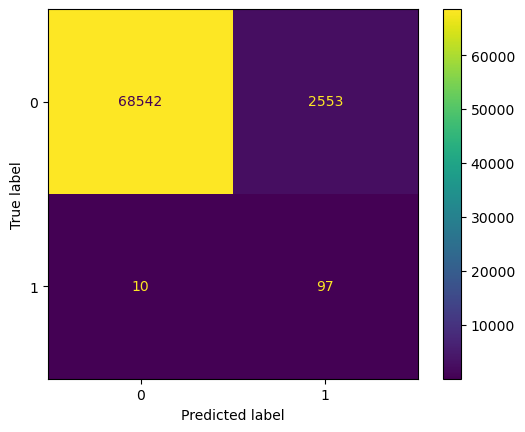

In [10]:
cm = confusion_matrix(y_test, y_test_lrc)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Logistinen regressio tunnistaa parhaiten petoksia, mutta ennustaa paljon ok-tapahtumia petoksiksi.

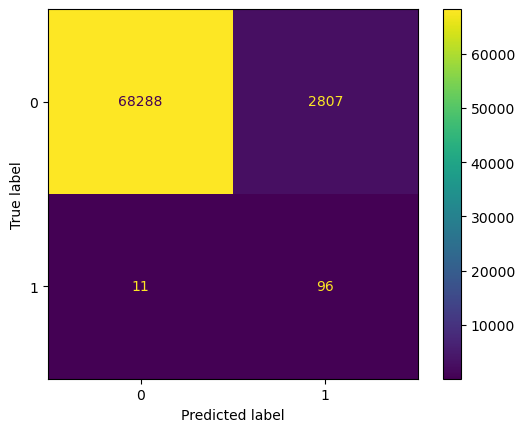

In [11]:
cm = confusion_matrix(y_test, y_test_dtc)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

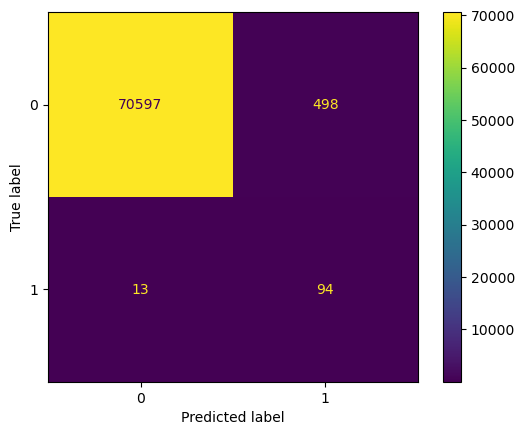

In [12]:
cm = confusion_matrix(y_test, y_test_rfc)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Satunnaismetsä erehtyy vähiten ok-tapahtumissa, mutta tunnistaa huonoiten petoksia.

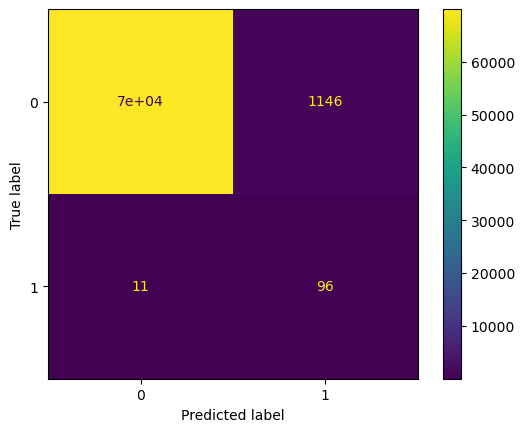

In [13]:
cm = confusion_matrix(y_test, y_test_gbc)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Gradienttitehostus on hyvä kompromissi väärien negatiivisten ja väärien positiivisten väliltä.